# Proyecto II: Detección de Cáncer

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">El contexto de este proyecto es desarrollar una aplicación que sea capaz de clasificar resonancias electromagnéticas cerebrales para detectar cáncer. Como se ha mencionado el objetivo es crear un modelo que clasifique las imágenes de estas resonancias y que establezca si el paciente está sano o sufre cáncer cerebral.</div>

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Para lograr este objetivo vamos a utilizar una versión modificada del <a href="https://www.kaggle.com/preetviradiya/brian-tumor-dataset">dataset</a>, este dataset cuenta con una gran cantidad de imágenes divididas entre imágenes de resonancias con cáncer y resonancias de personas sanas. Como en el proyecto anterior, se proporciona un modelo ya entrenaddo sobre este problema si el proceso de entrenamiento resulta demasiado lento.</div>

- ## Paso 1: Construir el generador de datos

Debido a que la cantidad de imágenes es bastante altas como para tenerlas todas a la vez en memoria, se utilizará una herramienta que ofreze **Keras** para establecer un directorio desde el que extraer las imágenes de ambas clases.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = './images/tumor_dataset'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path,
    target_size=(128,128),
    batch_size=40,
    class_mode='binary'
)

Found 4432 images belonging to 2 classes.


- ## Paso 2: Constuir el modelo

En este paso se va a generar un modelo sin entrenar usando el framework de **Keras** y con una estructura de baja complejidad para tratar de resolver el problema de un forma sencilla 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import os

model = Sequential()

# Stack the layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3))) # Input layer
model.add(MaxPooling2D(2,2)) # Downsize the results
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5)) # Ignore some outputs to avoid overfitting
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten()) # Convert to 1D
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Output layer

# Setup the optimizer
opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0

- ## Paso 3: Entrenar el modelo

En este paso se va a entrenar el modelo construido en el paso anterior.

In [6]:
# Train the model
history = model.fit(train_generator, epochs=50, callbacks=[tensorboard_callback])

Epoch 1/50
111/111 [==============================] - 72s 650ms/step - loss: 0.2355 - accuracy: 0.9052
Epoch 2/50
111/111 [==============================] - 51s 459ms/step - loss: 0.2026 - accuracy: 0.9136
Epoch 3/50
111/111 [==============================] - 52s 466ms/step - loss: 0.1946 - accuracy: 0.9235
Epoch 4/50
111/111 [==============================] - 53s 472ms/step - loss: 0.1714 - accuracy: 0.9346
Epoch 5/50
111/111 [==============================] - 51s 454ms/step - loss: 0.1558 - accuracy: 0.9427
Epoch 6/50
111/111 [==============================] - 53s 471ms/step - loss: 0.1407 - accuracy: 0.9463
Epoch 7/50
111/111 [==============================] - 52s 469ms/step - loss: 0.1354 - accuracy: 0.9483
Epoch 8/50
111/111 [==============================] - 50s 450ms/step - loss: 0.1068 - accuracy: 0.9592
Epoch 9/50
111/111 [==============================] - 51s 461ms/step - loss: 0.1066 - accuracy: 0.9596
Epoch 10/50
111/111 [==============================] - 51s 459ms/step - l

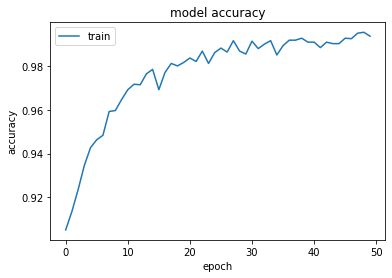

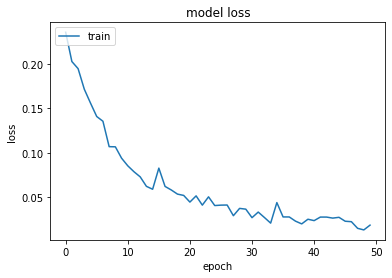

In [10]:
import matplotlib.pyplot as plt
# Plot the training data
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [11]:
model.save('tumor_model.h5')

- ## Paso 4: Desarrollar la aplicación

Para este paso vamos a desarrollar un script que se encargue de cargar el modelo entrenado y de tomar imágenes, adaptarlas y procesarlas con el modelo para determinar si la resonancia es de un cerebro sano

In [60]:
class MRI_Classifier():
    def __init__(self, model_file='./models/tumor_model/tumor.h5'):
        from tensorflow.keras.models import load_model
        
        self.model_file = model_file
        self.model = load_model(model_file)
        self.input_shape = self.model.input_shape[1:3]
        
        self.__healthy__ = 1
        self.__tumor__ = 0
    
    def proccessMRI(self, image):
        from tensorflow.image import resize
        import numpy as np
        im = resize(image, self.input_shape)
        im = np.expand_dims(im, 0)
        
        output = self.model(im)
        evaluation = np.around(output.numpy()[0][0])
        if evaluation == self.__healthy__:
            msg = 'Healthy MRI Detected'
        elif evaluation == self.__tumor__:
            msg = 'Tumorous MRI Detected'
        
        return msg

In [61]:
mri = MRI_Classifier()

- ## Paso 5: Probar la aplicación

Finalmente, se realiza una prueba para comprobar que la aplicación funciona como es debido usando las imágenes que se encuentran en la ruta `./images/tumor_test`.

In [58]:
import cv2
im_healthy = cv2.imread('./images/tumor_test/healthy-test.jpeg')
im_tumor0 = cv2.imread('./images/tumor_test/tumor-test.jpg')
im_tumor1 = cv2.imread('./images/tumor_test/tumor-test1.jpg')

In [62]:
print(mri.proccessMRI(im_healthy))
print(mri.proccessMRI(im_tumor0))
print(mri.proccessMRI(im_tumor1))

Healthy MRI Detected
Tumorous MRI Detected
Tumorous MRI Detected
